# Proyecto 1 - Analítica de textos
---
### Grupo 3: Apoyo a diagnóstico
*Laura Quiroga - 201922965*  
*Diego Rodriguez - 201923986*  
*Juan Pablo Galvis - 201922278* 




### Instalación e importación de librerías

In [ ]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')
!pip install pandas_profiling

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install ipywidgets

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
 # Instalación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.base import BaseEstimator, ClassifierMixin
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns

### Perfilamiento y entendimiento de los datos

#### Lectura de los datos

In [ ]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('data/text_data.csv', sep=',', encoding = 'utf-8', nrows=6000)
# Asignación a una nueva variable de los datos leidos
data_t=data

#### Entendimiento de los datos

In [ ]:
# Primera revisión de columnas y registros de la tabla.
data_t_shape = data_t.shape
data_t_shape

(6000, 2)

In [ ]:
# Se muestran los datos
data_t.sample(20)

,medical_abstracts,problems_described
2451,"Celiac disease, brain atrophy, and dementia. W...",5
5915,Review of the all-polyethylene tibial componen...,5
901,A pilot study of intermediate-dose methotrexat...,5
4518,Hemorrhagic pituitary adenomas: clinicopatholo...,5
5383,Spontaneous bacterial peritonitis due to Salmo...,2
765,Right-left disorientation in dementia of the A...,3
2797,Electroencephalographic parameters in assessin...,3
5541,Prevalence of unsuspected mitral regurgitation...,4
1213,HTLV-I-associated leukemia/lymphoma in south F...,1
3203,Glucose polymers as an alternative to glucose ...,2


In [ ]:
abstracts = data_t.copy()
abstracts['Conteo'] = [len(x) for x in abstracts['medical_abstracts']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(abstracts)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Preparación de los datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
1. Limpieza de los datos.
2. Tokenización.
3. Normalización.

### 1. Limpieza de los datos

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    ########################### :)
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def split_on_numeric(words):
    """Split words on numeric/non-numeric boundary  :)"""
    new_words = []
    for word in words:
        w=""
        if not word.isalpha():
            new_word = re.split(r'(?<=\D)(?=\d)|(?<=\d)(?=\D)', word)
            for i in new_word:
                w += str(i)+" "
            new_words.append(w)
        else:
            new_words.append(word)
    return new_words
    

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        word.replace(" ", "")
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    ############################# :)
    new_words = []
    stop_words = set(stopwords.words('english'))
    for word in words:
        if not word in stop_words:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = split_on_numeric(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

### 2. Tokenización

In [ ]:
data_t['medical_abstracts'] = data_t['medical_abstracts'].apply(contractions.fix) 
#Aplica la corrección de las contracciones

In [ ]:
data_t['words'] = data_t['medical_abstracts'].apply(word_tokenize).apply(preprocessing) 
#Aplica la eliminación del ruido
data_t.head()

,medical_abstracts,problems_described,words
0,Cell lineage markers in human pancreatic cance...,1,"[cell, lineage, markers, human, pancreatic, ca..."
1,Fatal pulmonary venoocclusive disease secondar...,5,"[fatal, pulmonary, venoocclusive, disease, sec..."
2,High survival rate in advanced-stage B-cell ly...,5,"[high, survival, rate, advancedstage, bcell, l..."
3,Intracranial chordoma in a preadolescent. Case...,1,"[intracranial, chordoma, preadolescent, case, ..."
4,Analysis of prognostic factors and clinicopath...,3,"[analysis, prognostic, factors, clinicopatholo..."


### 3. Normalización

In [ ]:
#from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [ ]:
 def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer(language= 'english')
    n_words=[]
    for i in words:
        n_words.append(stemmer.stem(i))
    return n_words


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    #################################### :)
    lemmatizer = WordNetLemmatizer()
    n_words=[]
    for i in words:
        n_words.append(lemmatizer.lemmatize(i))
    return n_words

def stem_and_lemmatize(words):
    words_s = stem_words(words)
    words_l = lemmatize_verbs(words_s)
    return words_l


data_t_clean=data_t.copy()
for i in range(data_t_clean.shape[0]):
    data_t_clean['words'][i]=stem_and_lemmatize(data_t['words'][i])

data_t_clean.head()

#print(stem_and_lemmatize(plurals))
#data_t['words'] = data_t['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
#data_t.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,medical_abstracts,problems_described,words
0,Cell lineage markers in human pancreatic cance...,1,"[cell, lineag, marker, human, pancreat, cancer..."
1,Fatal pulmonary venoocclusive disease secondar...,5,"[fatal, pulmonari, venoocclus, diseas, seconda..."
2,High survival rate in advanced-stage B-cell ly...,5,"[high, surviv, rate, advancedstag, bcell, lymp..."
3,Intracranial chordoma in a preadolescent. Case...,1,"[intracrani, chordoma, preadolesc, case, repor..."
4,Analysis of prognostic factors and clinicopath...,3,"[analysi, prognost, factor, clinicopatholog, s..."


### 4. Selección de campos

Primero, se separa la variable predictora (problema descrito en el abstract) y los textos que se van a utilizar

In [ ]:
data_t_clean['words'] = data_t_clean['words'].apply(lambda x: ' '.join(map(str, x)))
data_t_clean

,medical_abstracts,problems_described,words
0,Cell lineage markers in human pancreatic cance...,1,cell lineag marker human pancreat cancer norma...
1,Fatal pulmonary venoocclusive disease secondar...,5,fatal pulmonari venoocclus diseas secondari ge...
2,High survival rate in advanced-stage B-cell ly...,5,high surviv rate advancedstag bcell lymphoma l...
3,Intracranial chordoma in a preadolescent. Case...,1,intracrani chordoma preadolesc case report cho...
4,Analysis of prognostic factors and clinicopath...,3,analysi prognost factor clinicopatholog stage ...
...,...,...,...
5995,Pseudocyst of the auricle. Case report and wor...,1,pseudocyst auricl case report world literatur ...
5996,Experimental contrast-associated nephropathy a...,4,experiment contrastassoci nephropathi clinic i...
5997,Eight and 12 week courses of cyclophosphamide ...,5,eight 12 week cours cyclophosphamid nephrot s...
5998,Genetic analysis of breast cancer in the cance...,5,genet analysi breast cancer cancer steroid hor...


In [ ]:
"""a =[]
def unificador(words):
  arraywords = words.split(" ")
  for word in arraywords:
    if word not in a:
      a.append(word)
      print(word)
data_t['as'] = data_t.apply(lambda x: unificador(x['words']), axis =1)
"""

'a =[]\ndef unificador(words):\n  arraywords = words.split(" ")\n  for word in arraywords:\n    if word not in a:\n      a.append(word)\n      print(word)\ndata_t[\'as\'] = data_t.apply(lambda x: unificador(x[\'words\']), axis =1)\n'

In [ ]:
X_data, y_data = data_t_clean['words'],data_t_clean['problems_described']
y_data

0       1
1       5
2       5
3       1
4       3
       ..
5995    1
5996    4
5997    5
5998    5
5999    5
Name: problems_described, Length: 6000, dtype: int64

Se transforma el texto para completar la matriz con la estrategia de TF_IDF

In [ ]:
'''
X_trainSVM, X_testSVM, Y_trainSVM, Y_testSVM = train_test_split(X_data, y_data, test_size=0.2, random_state=0)
vect = TfidfVectorizer()
X_tfidf = vect.fit_transform(X_data)
#Separar test de entrenamiento
Train_X_Tfidf = vect.transform(X_trainSVM)
Train_X_Tfidf = vect.transform(X_testSVM)
'''

'\nX_trainSVM, X_testSVM, Y_trainSVM, Y_testSVM = train_test_split(X_data, y_data, test_size=0.2, random_state=0)\nvect = TfidfVectorizer()\nX_tfidf = vect.fit_transform(X_data)\n#Separar test de entrenamiento\nTrain_X_Tfidf = vect.transform(X_trainSVM)\nTrain_X_Tfidf = vect.transform(X_testSVM)\n'

In [ ]:
vect = TfidfVectorizer()
X_tfidf = vect.fit_transform(X_data)
print(X_tfidf.shape)
X_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf)
#X_tfidf.toarray()[0]

(6000, 24784)


In [ ]:
X_svm = X_tfidf.copy()
X_nb = X_tfidf.copy()
X_lr = X_tfidf.copy()

### Creación y aplicación de los modelos de clasificación

Una vez se tiene la representación vectorial de cada uno de los textos, se utilizarán tres algoritmos de clasificación que permitan clasificar los abstracts según el problema que se está diagnosticando: Support Vector Machine, Naive Bayes classifier y Logistic regression.

### 1. Support Vector Machine

In [ ]:
#Separar test de entrenamiento
X_trainSVM, X_testSVM, Y_trainSVM, Y_testSVM = train_test_split(X_svm, y_data, test_size=0.2, random_state=0)

In [ ]:
X_trainSVM = X_trainSVM.to_numpy()
X_testSVM = X_testSVM.to_numpy()
type(X_trainSVM)

numpy.ndarray

In [ ]:
# defining parameter range
'''
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1],#, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear', 'poly', 'sigmoid', 'precomputed']}

partitions = KFold(n_splits=3, shuffle=True, random_state=0)
 
grid = GridSearchCV(SVC(), param_grid, verbose=3)
 
# fitting the model for grid search
grid.fit(X_trainSVM, Y_trainSVM)
'''
SVM = SVC(C=1, kernel='linear')
SVM.fit(X_trainSVM, Y_trainSVM)



SVC(C=1, kernel='linear')

In [ ]:
# y_pred_train=SVM.predict(X_trainSVM)
y_pred_test=SVM.predict(X_testSVM)

In [ ]:
# Se calcula el score del modelo de SVM con los hiperparámetros escogidos
# C=1, kernel = lineal
score = SVM.score(X_testSVM, Y_testSVM)
print(score)

0.5883333333333334


In [ ]:
# Se genera la matriz de confusión
confusion_matrix(Y_testSVM, y_pred_test)

array([[178,   6,   6,   3,  48],
       [ 12,  57,   4,   2,  37],
       [ 14,   1,  66,  10,  78],
       [ 10,   3,   7, 185,  68],
       [ 52,  35,  38,  60, 220]])

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


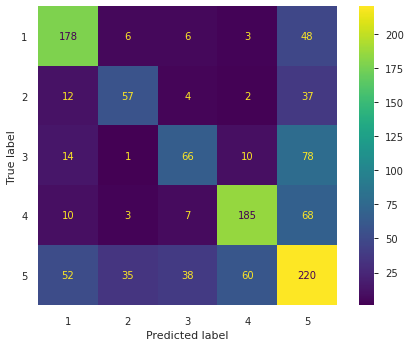

In [ ]:
# Se grafica la matriz de confusión
plot_confusion_matrix(SVM, X_testSVM, Y_testSVM)  
plt.show()  

In [ ]:
# Mostrar reporte de clasificación
print(classification_report(Y_testSVM, y_pred_test))

NameError: name 'Y_testSVM' is not defined

In [ ]:
# Se prueba el modelo con un segundo set de hiperparámetros
# C=1 , kernel= poly
SVM2 = SVC(C=1, kernel='poly')
SVM2.fit(X_trainSVM, Y_trainSVM)
y_pred_test=SVM2.predict(X_testSVM)

SVC(C=1, kernel='poly')

In [ ]:
# Se calcula el score del modelo de SVM con los segundos hiperparámetros escogidos
score = SVM2.score(X_testSVM, Y_testSVM)
print(score)

0.3175


Se escogen los hiperparámetros que dieron como resultado el mejor modelo teniendo en cuenta que por el tamaño de los datos y la complejidad del modelo no se pudieron probar muchas combinaciones haciedo la grid search. Finalmente, se escogen los siguientes hiperparámetros: c=1, kernel=lineal. 

### 2. Naive Bayes Classifier

In [ ]:
#Separar test de entrednamiento
X_train_NBC, X_test_NBC, Y_train_NBC, Y_test_NBC = train_test_split(X_nb, y_data, test_size=0.2, random_state=0)

In [ ]:
X_train_NBC = X_train_NBC.to_numpy()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#Modelo Sin Hiperparametros
model = MultinomialNB()

In [ ]:
# Fijar el número de particiones
partitions = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
#Definimos la grilla de hiperparametros
param_grid = {'alpha':[1,2,3,4,5,6,7,10], 'fit_prior': [True, False]}

In [ ]:
#Buscamos el Mejor Modelo GridSearchCV
bModel = GridSearchCV(model, param_grid, cv=partitions)
bModel.fit(X_train_NBC, Y_train_NBC)
bModel.best_params_

{'alpha': 1, 'fit_prior': False}

In [ ]:
mejorModelo = MultinomialNB(alpha = 1, fit_prior=False)
mejorModelo.fit(X_train_NBC, Y_train_NBC)
mejorModelo.score(X_test_NBC, Y_test_NBC)

0.535

In [ ]:
y_pred = mejorModelo.fit(X_train_NBC, Y_train_NBC).predict(X_test_NBC)


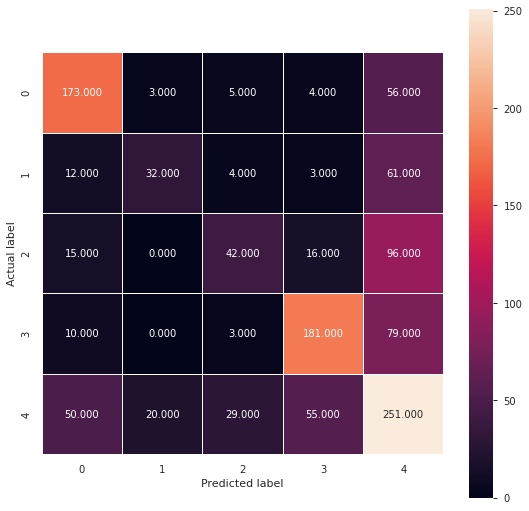

In [ ]:
# Generar matriz de confusión
cm = confusion_matrix(Y_test_NBC, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

### 3. Logistic regression

In [ ]:
X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(X_lr, y_data, test_size=0.2, random_state=0)

#### Búsqueda de hiper-parámetros

In [ ]:
# Fijar el número de particiones
partitions = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
# Establecer el espacio de búsqueda para los hiperparámetros a ajustar 
param_grid = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [ ]:
# Definir el modelo sin ningún valor para los hiperparámetros
baseReg = LogisticRegression(random_state=0)

In [ ]:
X_train_lr.head()

,0,1,2,3,4,5,6,7,8,9,...,24774,24775,24776,24777,24778,24779,24780,24781,24782,24783
3381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Utilizar GridSearch sobre el grid definido y con 10 particiones
bestModel = GridSearchCV(baseReg, param_grid, cv=partitions)
bestModel.fit(X_train_lr, Y_train_lr)

KeyboardInterrupt: 

In [ ]:
# Ver resultados de la búsqueda de los mejores hiperparámetros
bestModel.best_params_

{'solver': 'liblinear'}

#### Creación del estimador

In [ ]:
#regression = bestModel.best_estimator_

In [ ]:
regression = LogisticRegression(solver='liblinear', random_state=0)
regression = regression.fit(X_train_lr, Y_train_lr)
y_pred = regression.predict(X_test_lr)

In [ ]:
score = regression.score(X_test_lr, Y_test_lr)
print(score)

0.5658333333333333


#### Interpretación y métricas

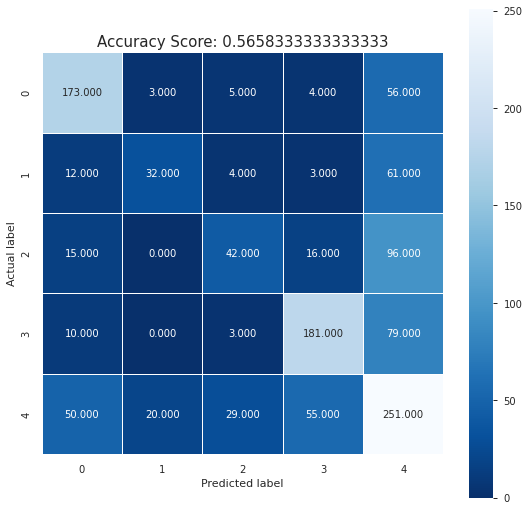

In [ ]:
# Generar matriz de confusión
cm = confusion_matrix(Y_test_lr, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
# Generar reporte de clasificación
print(classification_report(Y_test_lr, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.72      0.69       241
           2       0.58      0.29      0.38       112
           3       0.51      0.25      0.33       169
           4       0.70      0.66      0.68       273
           5       0.46      0.62      0.53       405

    accuracy                           0.57      1200
   macro avg       0.58      0.51      0.52      1200
weighted avg       0.57      0.57      0.55      1200



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6e5ab278-18a4-4f21-9f56-7e9bd2a2f5d9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>